In [4]:
# visualization
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
fe = fm.FontEntry(
    fname=r'/usr/share/fonts/truetype/nanum/NanumGothic.ttf', # ttf 파일이 저장되어 있는 경로
    name='NanumBarunGothic')                        # 이 폰트의 원하는 이름 설정
fm.fontManager.ttflist.insert(0, fe)              # Matplotlib에 폰트 추가
plt.rcParams.update({'font.size': 10, 'font.family': 'NanumBarunGothic'}) # 폰트 설정
plt.rc('font', family='NanumBarunGothic')
import seaborn as sns

# utils
import pandas as pd
import numpy as np
from tqdm import tqdm
import pickle
import warnings;warnings.filterwarnings('ignore')

# Model
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from lightgbm import LGBMRegressor
from xgboost import  XGBRegressor
from catboost import CatBoostRegressor

import eli5
from eli5.sklearn import PermutationImportance

import time

In [87]:
sy_train = pd.read_csv("/root/dt_train_add_data.csv")
sy_test = pd.read_csv("/root/dt_test_add_data.csv")

In [138]:
yh = pd.read_csv("/root/preprocessing.csv")

In [95]:
# train/test 구분을 위한 칼럼을 하나 만들어 줍니다.
sy_train['is_test'] = 0
sy_test['is_test'] = 1
concat = pd.concat([sy_train, sy_test])     # 하나의 데이터로 만들어줍니다.

In [98]:
# 위 처럼 아무 의미도 갖지 않는 칼럼은 결측치와 같은 역할을 하므로, np.nan으로 채워 결측치로 인식되도록 합니다.
concat['등기신청일자'] = concat['등기신청일자'].replace(' ', np.nan)
concat['거래유형'] = concat['거래유형'].replace('-', np.nan)
concat['중개사소재지'] = concat['중개사소재지'].replace('-', np.nan)

In [99]:
out = list(concat.columns[concat.isnull().sum() > 1000000])
out

['해제사유발생일',
 '등기신청일자',
 '거래유형',
 '중개사소재지',
 '단지소개기존clob',
 'k-135㎡초과',
 'k-홈페이지',
 'k-등록일자']

In [100]:
# 위에서 결측치가 100만개 이하인 변수들만 골라 새로운 concat_select 객체로 저장해줍니다.
selected = list(concat.columns[concat.isnull().sum() <= 1000000])
concat_select = concat[selected]

In [139]:
concat_select = yh

In [140]:
# 본번, 부번의 경우 float로 되어있지만 범주형 변수의 의미를 가지므로 object(string) 형태로 바꾸어주고 아래 작업을 진행하겠습니다.
concat_select['본번'] = concat_select['본번'].astype('str')
concat_select['부번'] = concat_select['부번'].astype('str')

In [141]:
# 먼저, 연속형 변수와 범주형 변수를 위 info에 따라 분리해주겠습니다.
continuous_columns = []
categorical_columns = []

for column in concat_select.columns:
    if pd.api.types.is_numeric_dtype(concat_select[column]):
        continuous_columns.append(column)
    else:
        categorical_columns.append(column)

print("연속형 변수:", continuous_columns)
print("범주형 변수:", categorical_columns)

연속형 변수: ['전용면적', '계약일', '층', '건축년도', 'k-전체동수', 'k-전체세대수', 'k-연면적', 'k-전용면적별세대현황(60㎡이하)', 'k-전용면적별세대현황(60㎡~85㎡이하)', 'k-85㎡~135㎡이하', '건축면적', '주차대수', '좌표X', '좌표Y', 'target', 'is_test', '해제발생일수', 'is_release', '계약년', '계약월', '강남여부', '신축여부']
범주형 변수: ['본번', '부번', '아파트명', '도로명', 'k-단지분류(아파트,주상복합등등)', 'k-세대타입(분양형태)', 'k-관리방식', 'k-복도유형', 'k-난방방식', 'k-건설사(시공사)', 'k-시행사', 'k-사용검사일-사용승인일', 'k-수정일자', '고용보험관리번호', '경비비관리형태', '세대전기계약방법', '청소비관리형태', '기타/의무/임대/임의=1/2/3/4', '단지승인일', '사용허가여부', '관리비 업로드', '단지신청일', '거래유형', '구', '동']


In [142]:
# 범주형 변수에 대한 보간
concat_select[categorical_columns] = concat_select[categorical_columns].fillna('NULL')

# 연속형 변수에 대한 보간 (선형 보간)
concat_select[continuous_columns] = concat_select[continuous_columns].interpolate(method='linear', axis=0)

In [143]:
# 시군구, 년월 등 분할할 수 있는 변수들은 세부사항 고려를 용이하게 하기 위해 모두 분할해 주겠습니다.
concat_select['구'] = concat_select['시군구'].map(lambda x : x.split()[1])
concat_select['동'] = concat_select['시군구'].map(lambda x : x.split()[2])
del concat_select['시군구']

concat_select['계약년'] = concat_select['계약년월'].astype('str').map(lambda x : x[:4])
concat_select['계약월'] = concat_select['계약년월'].astype('str').map(lambda x : x[4:])
del concat_select['계약년월']

KeyError: '시군구'

In [144]:
all = list(concat_select['구'].unique())
gangnam = ['강서구', '영등포구', '동작구', '서초구', '강남구', '송파구', '강동구']
gangbuk = [x for x in all if x not in gangnam]

assert len(all) == len(gangnam) + len(gangbuk)       # 알맞게 분리되었는지 체크합니다.

In [145]:
# 강남의 여부를 체크합니다.
is_gangnam = []
for x in concat_select['구'].tolist() :
  if x in gangnam :
    is_gangnam.append(1)
  else :
    is_gangnam.append(0)

# 파생변수를 하나 만릅니다.
concat_select['강남여부'] = is_gangnam

In [146]:
# 따라서 2009년 이후에 지어졌으면 비교적 신축이라고 판단하고, 신축 여부 변수를 제작해보도록 하겠습니다.
concat_select['신축여부'] = concat_select['건축년도'].apply(lambda x: 1 if x >= 2009 else 0)

In [147]:
# 이제 다시 train과 test dataset을 분할해줍니다. 위에서 제작해 놓았던 is_test 칼럼을 이용합니다.
dt_train = concat_select.query('is_test==0')
dt_test = concat_select.query('is_test==1')

# 이제 is_test 칼럼은 drop해줍니다.
dt_train.drop(['is_test'], axis = 1, inplace=True)
dt_test.drop(['is_test'], axis = 1, inplace=True)
print(dt_train.shape, dt_test.shape)

(1118822, 46) (9272, 46)


In [148]:
# dt_test의 target은 일단 0으로 임의로 채워주도록 하겠습니다.
dt_test['target'] = 0

In [149]:
# 파생변수 제작으로 추가된 변수들이 존재하기에, 다시한번 연속형과 범주형 칼럼을 분리해주겠습니다.
continuous_columns_v2 = []
categorical_columns_v2 = []

for column in dt_train.columns:
    if pd.api.types.is_numeric_dtype(dt_train[column]):
        continuous_columns_v2.append(column)
    else:
        categorical_columns_v2.append(column)

print("연속형 변수:", continuous_columns_v2)
print("범주형 변수:", categorical_columns_v2)

연속형 변수: ['전용면적', '계약일', '층', '건축년도', 'k-전체동수', 'k-전체세대수', 'k-연면적', 'k-전용면적별세대현황(60㎡이하)', 'k-전용면적별세대현황(60㎡~85㎡이하)', 'k-85㎡~135㎡이하', '건축면적', '주차대수', '좌표X', '좌표Y', 'target', '해제발생일수', 'is_release', '계약년', '계약월', '강남여부', '신축여부']
범주형 변수: ['본번', '부번', '아파트명', '도로명', 'k-단지분류(아파트,주상복합등등)', 'k-세대타입(분양형태)', 'k-관리방식', 'k-복도유형', 'k-난방방식', 'k-건설사(시공사)', 'k-시행사', 'k-사용검사일-사용승인일', 'k-수정일자', '고용보험관리번호', '경비비관리형태', '세대전기계약방법', '청소비관리형태', '기타/의무/임대/임의=1/2/3/4', '단지승인일', '사용허가여부', '관리비 업로드', '단지신청일', '거래유형', '구', '동']


In [151]:
# 아래에서 범주형 변수들을 대상으로 레이블인코딩을 진행해 주겠습니다.

# 각 변수에 대한 LabelEncoder를 저장할 딕셔너리
label_encoders = {}

# Implement Label Encoding
for col in tqdm( categorical_columns_v2 ):
    lbl = LabelEncoder()

    # Label-Encoding을 fit
    lbl.fit( dt_train[col].astype(str) )
    dt_train[col] = lbl.transform(dt_train[col].astype(str))
    label_encoders[col] = lbl           # 나중에 후처리를 위해 레이블인코더를 저장해주겠습니다.

    # Test 데이터에만 존재하는 새로 출현한 데이터를 신규 클래스로 추가해줍니다.
    for label in np.unique(dt_test[col].astype(str)):
      if label not in lbl.classes_: # unseen label 데이터인 경우
        lbl.classes_ = np.append(lbl.classes_, label) # 미처리 시 ValueError발생하니 주의하세요!

    dt_test[col] = lbl.transform(dt_test[col].astype(str))

100%|██████████| 25/25 [00:18<00:00,  1.39it/s]


In [152]:
# sepatrate target
y_train = dt_train['target']
X_train = dt_train.drop(['target'], axis=1)

# t/v 8:2
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=2023)
print("train:", X_train.shape)
print("val:", X_val.shape)
print("test:", y_train.shape)

train: (895057, 45)
val: (223765, 45)
test: (895057,)


In [153]:
X_train = X_train.rename(columns={"k-전용면적별세대현황(60㎡이하)": 'k-전용면적별세대현황(60이하)'})
X_train = X_train.rename(columns={"k-전용면적별세대현황(60㎡~85㎡이하)": 'k-전용면적별세대현황(60-85이하)'})
X_train = X_train.rename(columns={"k-85㎡~135㎡이하": 'k-85-135이하'})
X_train.columns

Index(['본번', '부번', '아파트명', '전용면적', '계약일', '층', '건축년도', '도로명',
       'k-단지분류(아파트,주상복합등등)', 'k-세대타입(분양형태)', 'k-관리방식', 'k-복도유형', 'k-난방방식',
       'k-전체동수', 'k-전체세대수', 'k-건설사(시공사)', 'k-시행사', 'k-사용검사일-사용승인일', 'k-연면적',
       'k-전용면적별세대현황(60이하)', 'k-전용면적별세대현황(60-85이하)', 'k-85-135이하', 'k-수정일자',
       '고용보험관리번호', '경비비관리형태', '세대전기계약방법', '청소비관리형태', '건축면적', '주차대수',
       '기타/의무/임대/임의=1/2/3/4', '단지승인일', '사용허가여부', '관리비 업로드', '좌표X', '좌표Y',
       '단지신청일', '해제발생일수', 'is_release', '거래유형', '구', '동', '계약년', '계약월', '강남여부',
       '신축여부'],
      dtype='object')

In [154]:
import re

def clean_column_names(column_names):
    cleaned_names = []
    for name in column_names:
        # 특수 문자 제거
        cleaned_name = re.sub(r'[^\w\s]', '', name)
        # 공백으로 대체
        cleaned_name = re.sub(r'\s+', ' ', cleaned_name)
        cleaned_names.append(cleaned_name.strip())  # 앞뒤 공백 제거
    return cleaned_names

In [155]:
# 특수 문자를 지우고 열 이름을 업데이트
new_column_names = clean_column_names(X_train.columns)

X_train.columns = new_column_names
X_train.columns

Index(['본번', '부번', '아파트명', '전용면적', '계약일', '층', '건축년도', '도로명', 'k단지분류아파트주상복합등등',
       'k세대타입분양형태', 'k관리방식', 'k복도유형', 'k난방방식', 'k전체동수', 'k전체세대수', 'k건설사시공사',
       'k시행사', 'k사용검사일사용승인일', 'k연면적', 'k전용면적별세대현황60이하', 'k전용면적별세대현황6085이하',
       'k85135이하', 'k수정일자', '고용보험관리번호', '경비비관리형태', '세대전기계약방법', '청소비관리형태',
       '건축면적', '주차대수', '기타의무임대임의1234', '단지승인일', '사용허가여부', '관리비 업로드', '좌표X',
       '좌표Y', '단지신청일', '해제발생일수', 'is_release', '거래유형', '구', '동', '계약년', '계약월',
       '강남여부', '신축여부'],
      dtype='object')

In [156]:
new_column_names = clean_column_names(X_val.columns)

X_val.columns = new_column_names
X_val.columns

Index(['본번', '부번', '아파트명', '전용면적', '계약일', '층', '건축년도', '도로명', 'k단지분류아파트주상복합등등',
       'k세대타입분양형태', 'k관리방식', 'k복도유형', 'k난방방식', 'k전체동수', 'k전체세대수', 'k건설사시공사',
       'k시행사', 'k사용검사일사용승인일', 'k연면적', 'k전용면적별세대현황60이하', 'k전용면적별세대현황6085이하',
       'k85135이하', 'k수정일자', '고용보험관리번호', '경비비관리형태', '세대전기계약방법', '청소비관리형태',
       '건축면적', '주차대수', '기타의무임대임의1234', '단지승인일', '사용허가여부', '관리비 업로드', '좌표X',
       '좌표Y', '단지신청일', '해제발생일수', 'is_release', '거래유형', '구', '동', '계약년', '계약월',
       '강남여부', '신축여부'],
      dtype='object')

In [157]:
custom_params = {
    "objective": "regression",          # Objective function for the model
    #"objective": "multiclass_ova",          # Objective function for the model
    "metric": "rmse",          # Evaluation metric
    "verbosity": 1,                    # Verbosity level (-1 for silent)
    "boosting_type": "gbdt",            # Gradient boosting type
    "random_state": 202,       # Random state for reproducibility

    # trial 3
    #'max_depth': 16, 'learning_rate': 0.2809822182195598, 'colsample_bytree': 0.7402162349533333, 'min_child_samples': 135, 'n_estimators': 32935
    # val: 3900

    # 200
    # 6442
    # 202s
    # LB 20948
    #'max_depth': 26, 'learning_rate': 0.27778610291951245, 'colsample_bytree': 0.7941646871126394, 'min_child_samples': 35, 'n_estimators': 1999

    # test
    #'max_depth': 26, 'learning_rate': 0.27778610291951245, 'colsample_bytree': 0.7941646871126394, 'min_child_samples': 1, 'n_estimators': 1999

    # t 10
    # 'max_depth': 70, 'learning_rate': 0.1691658243619739, 'min_child_samples': 112, 'n_estimators': 3368, 'num_leaves': 185955948249267175424

    # t 50
    # val 6227
    # 484s
    #'max_depth': 48, 'learning_rate': 0.14282403319858425, 'min_child_samples': 16, 'n_estimators': 3970

    # t 50 v2
    #'max_depth': 65, 'learning_rate': 0.11118999140437943, 'min_child_samples': 4, 'n_estimators': 4998

    #t 50 v3
    #'max_depth': 63, 'learning_rate': 0.10930819249859756, 'min_child_samples': 17, 'n_estimators': 5987

    #'max_depth': 42, 'learning_rate': 0.11481338072063317, 'min_child_samples': 23, 'n_estimators': 6970
    #'max_depth': 46, 'learning_rate': 0.12542767067079164, 'min_child_samples': 14, 'n_estimators': 6205

    #t46
    'max_depth': 55, 'learning_rate': 0.11176798674487542, 'min_child_samples': 14, 'n_estimators': 6730
}

In [26]:
cat_params = {
    "loss_function": "RMSE",                # Objective function for the model
    "eval_metric": "RMSE",                  # Evaluation metric
    "verbose": True,                       # Verbosity level (False for silent)
    "boosting_type": "Plain",               # Gradient boosting type (for CatBoost, default is Plain)
    #"boosting_type": "Ordered",               # Gradient boosting type (for CatBoost, default is Plain)
    "random_seed": 202,                     # Random seed for reproducibility

    # search
    #'max_depth': 9, 'learning_rate': 0.15928282253910364, 'min_child_samples': 37, 'n_estimators': 4301

    # 15
    'max_depth': 9, 'learning_rate': 0.14810002488624377, 'min_child_samples': 138, 'n_estimators': 5497
}

In [158]:
# LGBM
start_time = time.time()
#lgbm = LGBMRegressor()
lgbm = LGBMRegressor(**custom_params)
lgbm.fit(X_train, y_train)
pred = lgbm.predict(X_val)
print(f'LGBM\n RMSE: {np.sqrt(metrics.mean_squared_error(y_val, pred))}')
end_time = time.time()
training_time = end_time - start_time
print(f'Training Time: {training_time} seconds')
model = lgbm

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.068582 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5944
[LightGBM] [Info] Number of data points in the train set: 895057, number of used features: 45
[LightGBM] [Info] Start training from score 58000.483999
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
LGBM
 RMSE: 6087.339149153762
Training Time: 76.1461877822876 seconds


In [27]:
# CatBoost
start_time = time.time()
#cat = CatBoostRegressor()
cat = CatBoostRegressor(**cat_params)
cat.fit(X_train, y_train)
pred = cat.predict(X_val)
print(f'CatBoost\n RMSE: {np.sqrt(metrics.mean_squared_error(y_val, pred))}')
end_time = time.time()
training_time = end_time - start_time
print(f'Training Time: {training_time} seconds')
model = cat

0:	learn: 41833.7859751	total: 315ms	remaining: 28m 52s
1:	learn: 38190.3365806	total: 574ms	remaining: 26m 17s
2:	learn: 34977.8395753	total: 820ms	remaining: 25m 1s
3:	learn: 32234.5490008	total: 1.08s	remaining: 24m 45s
4:	learn: 29951.7564621	total: 1.34s	remaining: 24m 33s
5:	learn: 28025.3421533	total: 1.6s	remaining: 24m 29s
6:	learn: 26472.5452750	total: 1.85s	remaining: 24m 9s
7:	learn: 25156.0687298	total: 2.12s	remaining: 24m 11s
8:	learn: 24009.4162217	total: 2.38s	remaining: 24m 8s
9:	learn: 23075.8144726	total: 2.64s	remaining: 24m 8s
10:	learn: 22218.6303994	total: 2.9s	remaining: 24m 7s
11:	learn: 21527.9466673	total: 3.17s	remaining: 24m 9s
12:	learn: 20964.6958791	total: 3.42s	remaining: 24m 5s
13:	learn: 20380.7717653	total: 3.69s	remaining: 24m 4s
14:	learn: 19953.5793573	total: 3.95s	remaining: 24m 2s
15:	learn: 19519.9570539	total: 4.19s	remaining: 23m 55s
16:	learn: 19179.0836505	total: 4.45s	remaining: 23m 54s
17:	learn: 18864.1953382	total: 4.71s	remaining: 23m

In [123]:
X_test = dt_test.drop(['target'], axis=1)

In [124]:
X_test = X_test.rename(columns={"k-전용면적별세대현황(60㎡이하)": 'k-전용면적별세대현황(60이하)'})
X_test = X_test.rename(columns={"k-전용면적별세대현황(60㎡~85㎡이하)": 'k-전용면적별세대현황(60-85이하)'})
X_test = X_test.rename(columns={"k-85㎡~135㎡이하": 'k-85-135이하'})
X_test.columns

# 특수 문자를 지우고 열 이름을 업데이트
new_column_names = clean_column_names(X_test.columns)

X_test.columns = new_column_names
X_test.columns

Index(['번지', '본번', '부번', '아파트명', '전용면적', '계약일', '층', '건축년도', '도로명',
       'k단지분류아파트주상복합등등', 'k전화번호', 'k팩스번호', 'k세대타입분양형태', 'k관리방식', 'k복도유형',
       'k난방방식', 'k전체동수', 'k전체세대수', 'k건설사시공사', 'k시행사', 'k사용검사일사용승인일', 'k연면적',
       'k주거전용면적', 'k관리비부과면적', 'k전용면적별세대현황60이하', 'k전용면적별세대현황6085이하', 'k85135이하',
       'k수정일자', '고용보험관리번호', '경비비관리형태', '세대전기계약방법', '청소비관리형태', '건축면적', '주차대수',
       '기타의무임대임의1234', '단지승인일', '사용허가여부', '관리비 업로드', '좌표X', '좌표Y', '단지신청일',
       '기준금리', '미국기준금리', 'GDP', '가계신용금액', '가계대출금액', '판매신용금액', '본원통화말잔계절조정계열',
       '현금통화', '중앙은행 대 예금취급기관부채', '대출평균 1 연', '기업대출 연리', '대기업대출 연리',
       '중소기업대출 연리', '운전자금대출 연리', '시설자금대출 연리', '상업어음할인 연리', '기업일반자금대출 연리',
       '가계대출 연리', '소액대출 500만원 이하 연리', '주택담보대출 연리', '고정형 주택담보대출 연리',
       '변동형 주택담보대출 연리', '예적금담보대출 연리', '보증대출 연리', '전세자금대출 연리', '일반신용대출 2 연리',
       '집단대출 2 연리', '공공및기타부문대출 연리', '구', '동', '계약년', '계약월', '강남여부', '신축여부'],
      dtype='object')

In [125]:
model

LGBMRegressor(learning_rate=0.11176798674487542, max_depth=55, metric='rmse',
              min_child_samples=14, n_estimators=6730, objective='regression',
              random_state=202, verbosity=1)

In [126]:
real_test_pred = model.predict(X_test)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


In [127]:
real_test_pred

array([193867.81970746, 301919.0759656 , 213118.89536443, ...,
        66461.91824402,  36431.96199623,  29625.93980089])

In [128]:
# 앞서 예측한 예측값들을 저장합니다.
preds_df = pd.DataFrame(real_test_pred.astype(int), columns=["target"])
preds_df.to_csv('/root/LGBM_SH_base.csv', index=False)

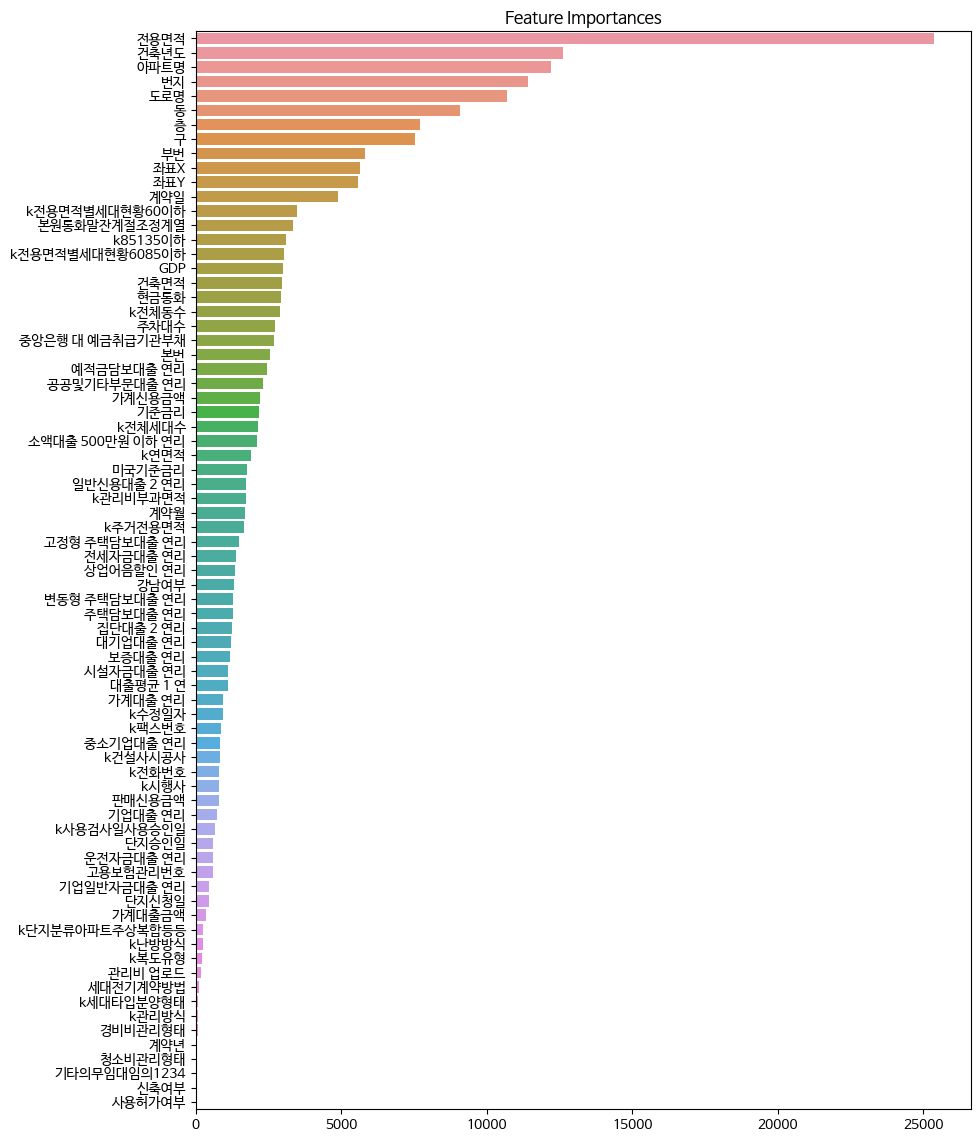

In [131]:
# 위 feature importance를 시각화해봅니다.

importances = pd.Series(model.feature_importances_, index=list(X_train.columns))
importances = importances.sort_values(ascending=False)

plt.figure(figsize=(10,14))
plt.title("Feature Importances")
sns.barplot(x=importances, y=importances.index)
plt.show()

In [137]:
sy = concat_select